A notebook to handle figures for the (revisions of) the yoder et al. 2016 Global/Nepal ETAS paper.

In [13]:
#
%load_ext autoreload
%autoreload 2
%matplotlib inline

import datetime as dtm
import matplotlib.dates as mpd
import pytz
tzutc = pytz.timezone('UTC')

#import operator
import math
import random
import numpy
import scipy
import scipy.optimize as spo
import itertools
import sys
#import scipy.optimize as spo
import os
import operator
#from PIL import Image as ipp
import multiprocessing as mpp
#
import matplotlib
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
#import functools
#
#import shapely.geometry as sgp
#
from mpl_toolkits.basemap import Basemap as Basemap
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from geographiclib.geodesic import Geodesic as ggp
#
#import ANSStools as atp
from yodiipy import ANSStools as atp
#
import contours2kml
import globalETAS as gep
from eq_params import *
#
import random
import geopy
#
#colors_ =  mpl.rcParams['axes.color_cycle']
colors_ = ['b', 'g', 'r', 'c', 'm', 'y', 'k']		# make sure these are correct...
#
emc = {'lat':32.13, 'lon':-115.30, 'event_date':dtm.datetime(2010,4,4,22,40,41, tzinfo=pytz.timezone('UTC'))}
nepal_epi_lon = 84.698
nepal_epi_lat = 28.175

#
# set up dict objects for different earthquakes. maybe from eq_params.py ?
param_keys = ['lat_center', 'lon_center', 'to_dt', 'mc', 'mc_auto', 'cat_len_plus']
nepal_params = {key:val for key,val in zip(param_keys, [nepal_epi_lat, nepal_epi_lon, 
                                                        dtm.datetime(2015,4,30, tzinfo=pytz.timezone('UTC')),
                                                        4.0, 4.5, 220])}
emc_params =   {key:val for key,val in zip(param_keys, [emc['lat'], emc['lon'],
                                                      emc['event_date'] + dtm.timedelta(days=5), 2.5, 5.5, 220])}

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### some random geopy bits:
  - easy syntax for great-circle or vincenty (more precise, iterative model) geodetic distances
  - forward and reverse geocoding
  

In [15]:
from geopy.distance import vincenty
from geopy.distance import great_circle
newport_ri = (41.49008, -71.312796)
cleveland_oh = (41.499498, -81.695391)
print(vincenty(newport_ri, cleveland_oh).miles)
print(great_circle(newport_ri, cleveland_oh).miles)

from geopy.geocoders import Nominatim
geolocator = Nominatim()
#location = geolocator.geocode("175 5th Avenue NYC")
location = geolocator.geocode("509 S Waiola Ave, La Grange IL")
print(location.address)
print(location.point)

538.3904451566326
537.1485284062816
509, South Waiola Avenue, La Grange, Cook County, Illinois, 60525, United States of America
41 48m 16.8175s N, 87 52m 35.5949s W


### ETAS and ROC figures
  - ETAS map
    - include recent (shortly before forecast date) earthquakes
  - ROC analysis
  
  Also include:
    - ETAS forecast catalog $t<t_0$
    - ETAS test catalog $t>t_0$
    - ETAS data.xyz file
    - Image(s)
    - KML
    - ROC table(s)
  
  For now, copy the make_Nepal_figs from nepal_figs.py. we'll move this to the original, or a new, module when we work out the bugs.

In [17]:
from nepal_figs import *

class nepal__ROC_script(object):
    def __init__(self, fignum=0, mcs = [4., 5., 6., 7.], n_cpu=None):
        # this needs to be rewritten a bit to:
        # 1) use the same color for each magnitude
        # 2) should probably use the roc_generic class; see _rocs3()
        #
        # full, one stop shopping script for nepal ROC analysis.
        #
        # first, get nepal ETAS objects:
        etas_fc, etas_test = etas_analyzer.nepal_etas_roc()
        test_catalog = etas_test.catalog
        #
        x0 = nepal_epi_lon
        y0 = nepal_epi_lat
        mag=7.8
        L_r = .5*10**(.5*mag - 1.76)
        xyz = etas_fc.ETAS_array
        #
        # now, replace all of this "get x,y and ROC" stuff with the optimizers.roc_tools equivalents.
        roc_xyz_handler = ROC_xyz_handler(xyz, list(zip(test_catalog['lon'], test_catalog['lat'], test_catalog['mag'])))
        # ----- 27 july stop.
        #
        X_set = sorted(list(set(xyz['x'])))
        Y_set = sorted(list(set(xyz['y'])))
        nx = len(X_set)
        ny = len(Y_set)
        get_site = lambda x,y: int(round((x-etas_fc.lons[0]+.5*etas_fc.d_lon)/etas_fc.d_lon)) + int(round((y-etas_fc.lats[0]+.5*etas_fc.d_lat)/etas_fc.d_lat))*nx
        #
        xyz_r = xyz.copy()
        for j,(x,y,z) in enumerate(xyz_r):
            xyz_r['z'][j]=1./(dist_to(x,y,x0,y0) + .5*L_r)
        #
        Zs = sorted(list(xyz['z'].copy()))
        Zs_r = sorted(list(xyz_r['z'].copy()))
        #
        eq_site_zs = [[xyz['z'][get_site(eq['lon'], eq['lat'])], eq['mag']] for eq in test_catalog]
        #
        plt.figure(fignum)
        plt.clf()
        plt.plot(range(2), range(2), ls='--', color='m', lw=3., alpha=.75, zorder=2)
        FHs = {}        # we'll use mc as a key, FH as a val: {mc:[FH]...}
        for j,mc in enumerate(mcs):
            clr = colors_[j%len(colors_)]
            roc = roc_generic.ROC_mpp(n_procs=n_cpu, Z_events=[z for z,m in eq_site_zs if m>=mc], Z_fc=Zs, h_denom=None, f_denom=None, f_start=0, f_stop=None)
            a=roc.calc_roc()        # no parameters, and in fact no return value, but it's never a bad idea to leave a place-holder for one.
            #
            plt.plot(roc.F, roc.H, ls='-', color=clr, marker='', lw=2.5, label='$m_c=%.2f$' % mc)
            #FHs[mc]=[[f,h] for f,h in zip(roc.F, roc.H)]
            #
            roc = roc_generic.ROC_mpp(n_procs=n_cpu, Z_events=[z for z,m in eq_site_zs if m>=mc], Z_fc=Zs_r, h_denom=None, f_denom=None, f_start=0, f_stop=None)
            roc.calc_roc()
            plt.plot(roc.F, roc.H, ls='--', color=clr, marker='', lw=2.5, label='$m_c=%.2f$' % mc)
            #
            plt.show()    # just in case...
    
    
        #ROC_n = roc_normalses(etas_fc, test_catalog=None, to_dt=None, cat_len=120., mc_rocs=[4.5, 5.0, 6.0, 7.0], fignum=fignum, do_clf=True)
        #
        # now, make a toy catalog:
        #etas_toy = Toy_etas_invr(etas_in=etas_fc, mainshock={'mag':7.3, 'lon':84.698, 'lat':28.175})
        #
        #ROC_t = roc_normalses(etas_toy, test_catalog=None, to_dt=None, cat_len=120., mc_rocs=[4.5, 5.0, 6.0, 7.0], fignum=fignum, do_clf=False, roc_ls='--')
        #
        # now, some random catalogs:
        for j in range(25):
            this_etas = etas_analyzer.Toy_etas_random(etas_in=etas_fc)
            FH = etas_analyzer.roc_normal(this_etas, fignum=None)
            plt.plot(*zip(*FH), marker='.', ls='', alpha=.6)
        #
        self.__dict__.update(locals())
        #


numba imported
*****************
DEPRICATION WARNING:
This module is being depricated; look at yodiipy.optimizers.roc_tools()
and possibly something like etas_roc_tools.py in the globalETAS folder.
this module contains some working code... and some not working code, so be very very careful,
particularly when running the more optimized codes.
NOTE: the Aray() (shared memory) vs piped mpp tests are probably worth keeping, particularly the Array() code sample.


In [26]:
import global_etas_auto
#Location
#    18.515°N 145.529°E

aa=global_etas_auto.auto_etas(lon_center=145.529, lat_center=18.515, d_lat_0=1.,
                              d_lon_0=1., dt_0=30, Lr_factor=5., mc_0=2.5)


data handle fetched...
 no file.
mainshock data:  {'lat': 18.869599999999998, 'event_date': numpy.datetime64('2016-06-30T20:53:29.570000-0500'), 'event_date_float': 736146.07881446765, 'mag': 4.4000000000000004, 'lon': 145.52090000000001, 'depth': 223.25999999999999} 1.37711435167 0.0618594174678 0.065372738694
data handle fetched...
 no file.
biggest event(s):  [(datetime.datetime(2014, 1, 11, 17, 34, 35, 980000), 18.857, 145.5108, 4.7, 103.96, 735244.7323608797), (datetime.datetime(2015, 12, 8, 19, 42, 14, 290000), 18.8274, 145.5691, 4.7, 199.03, 735940.8209987269)]
begin globalETAS.__init()__
Overriding t0 for ETAS calculations. using catalog start, t0 = t_now - catlen (1825.000000) = 2011-08-01 04:15:41.901447+00:00
fetch and process catalog.
etas_prams:  {'lats': [18.807740582532158, 18.931459417467838], 'do_recarray': True, 'lons': [145.455527261306, 145.58627273869402], 'date_range': [datetime.datetime(1990, 1, 1, 0, 0, tzinfo=<UTC>), datetime.datetime(2016, 7, 30, 4, 15, 41, 90

/home/myoder/Documents/Research/yoder/globalETAS/globalETAS.py:1338: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if incat==None:
/home/myoder/Documents/Research/yoder/globalETAS/globalETAS.py:1367: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if incat==None or (hasattr(incat, '__len__') and len(incat)==0):
/home/myoder/Documents/Research/yoder/globalETAS/globalETAS.py:1629: RuntimeWarning: divide by zero encountered in true_divide
  cov = numpy.dot(numpy.array(list(zip(*cat_prime))),numpy.array(cat_prime))/n_dof


R:  <multiprocessing.pool.ApplyResult object at 0x7f4b79fe7d30>
results fetched.
catalog fetched and processed.
ETAS over etas_cat_range/xyz_range:  ([0, 20], None)
make_etas():
etas_mpp worker xyz_range:  [0, 4]
begin globalETAS.__init()__
Overriding t0 for ETAS calculations. using catalog start, t0 = t_now - catlen (1825.000000) = 2011-08-01 04:15:45.506805+00:00
ETAS over etas_cat_range/xyz_range:  ([0, 20], [0, 4])


/home/myoder/Documents/Research/yoder/globalETAS/globalETAS.py:226: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if catalog==None:


begin make_etas_rtree()
len(local_lattice_dict):  4
Indices initiated. begin ETAS ::  [0, 20]
finished calculateing ETAS (rtree). wrap up in recarray and return.
etas complete (from mpp_rtree run() loop); now pipe back([0, 20])
now gather sub-arrays...
ETAS complete.
now execute with root_prams:  {'lats': [18.807740582532158, 18.931459417467838], 'n_contours': 15, 'etas_fit_factor': 2.0, 'etas_xyz_range': None, 'p_cat': 1.1, 'etas_range_padding': 0.5, 'transform_type': 'equal_area', 'catdir': 'kml_auto', 'lons': [145.455527261306, 145.58627273869402], 'etas_range_factor': 10.0, 't_now': None, 'p_etas': None, 'mc': 2.5, 'fnameroot': 'etas_auto', 'd_lon': 0.1, 'etas_cat_range': None, 'contres': 10, 'kmldir': 'kml_auto', 'd_lat': 0.1, 'transform_ratio_max': 2.5, 'q_cat': 1.5, 'catlen': 1825.0, 'calc_etas': True, 'doplot': False}


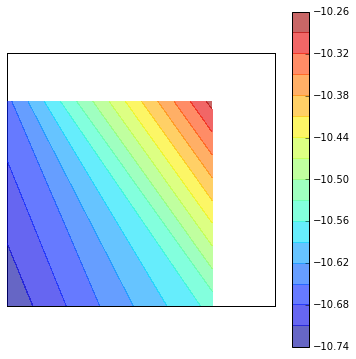

In [27]:
aa.make_etas_contour_map()

